In [248]:
import pytz
import json
from datetime import datetime, timedelta, timezone
import pandas as pd
import requests

%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

In [249]:
def to_iso(dt: datetime):
    return dt.isoformat(timespec='seconds').replace('+00:00', 'Z')

last_obs_timestamp = pytz.UTC.localize(datetime.fromtimestamp(1660032512))
start_dt = last_obs_timestamp + timedelta(minutes=1)

USGS_SITE = '01427510'
WATER_CONDITION_FEATURES = {'00010': 'watertemp', '00060': 'streamflow'}
ATMOSPHERIC_WEATHER_FEATURES = {'temp': 'airtemp', 'precip': 'precip', 'cloudcover': 'cloudcover', 'snow': 'snow', 'snowdepth': 'snowdepth'}
TIMESERIES_FREQUENCY = '1h'
FORECAST_HORIZON = 72 # hours

                           watertemp  streamflow
2022-08-09 04:15:00+00:00       25.8      1100.0
2022-08-09 04:30:00+00:00       25.8      1080.0
2022-08-09 04:45:00+00:00       25.7      1080.0
2022-08-09 05:00:00+00:00       25.6      1060.0
2022-08-09 05:15:00+00:00       25.5      1050.0
...                              ...         ...
2023-08-21 00:00:00+00:00       18.0      5190.0
2023-08-21 00:15:00+00:00       17.9      5190.0
2023-08-21 00:30:00+00:00       17.9      5140.0
2023-08-21 00:45:00+00:00       17.8      5140.0
2023-08-21 01:00:00+00:00       17.7      5100.0

[36180 rows x 2 columns]


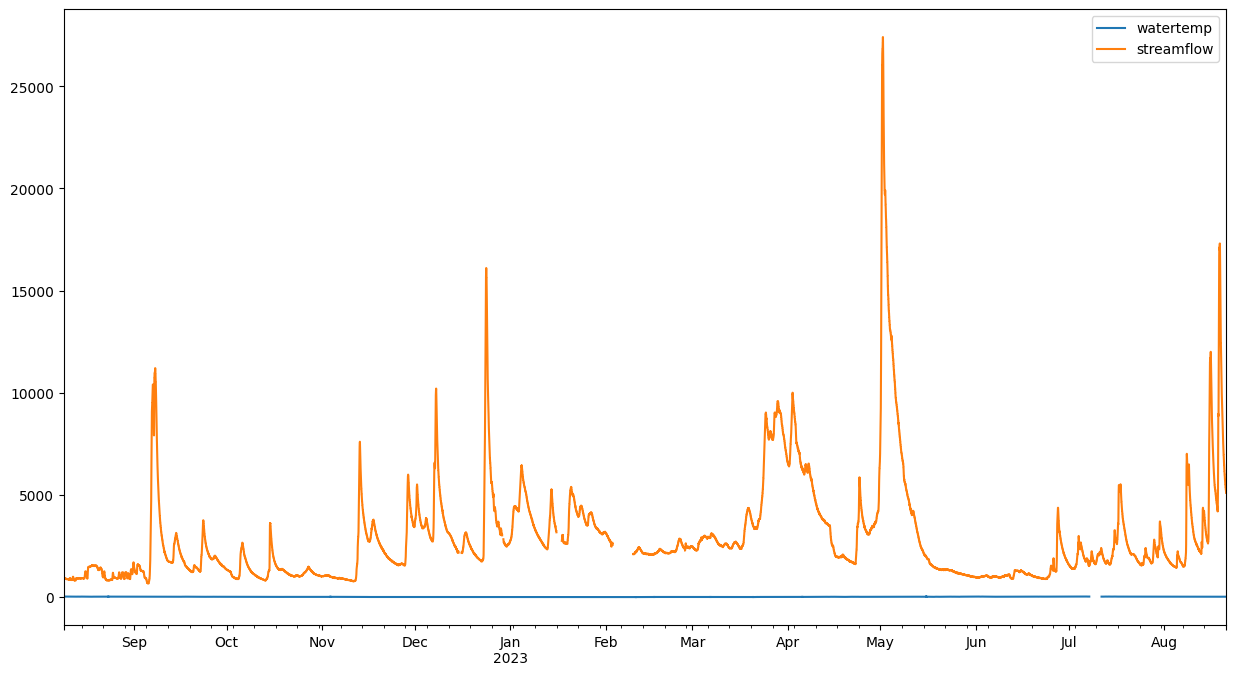

In [250]:
# fetch most recent available obs from nwis
res = requests.get(f'https://nwis.waterservices.usgs.gov/nwis/iv/?format=json&sites={USGS_SITE}&parameterCd={",".join(WATER_CONDITION_FEATURES.keys())}&siteStatus=all&startDT={to_iso(start_dt)}')

water = pd.DataFrame()
for series in res.json()['value']['timeSeries']:
  code = series['variable']['variableCode'][0]['value']
  values = series['values'][0]['value']

  df = pd.DataFrame(values)
  df = df.set_index(pd.to_datetime(df['dateTime'], utc=True))
  df = df.drop(['qualifiers', 'dateTime'], axis=1)
  df['value'] = df['value'].astype('float64')
  df = df.rename(columns={'value': WATER_CONDITION_FEATURES[code]})
  df.index.name = None

  water = water.join(df, how='outer')

print(water)

water.plot()
plt.show()

                           airtemp  precip  snow  snowdepth  cloudcover
2023-06-09 04:00:00+00:00     51.6     0.0   0.0        0.0        91.6
2023-06-09 05:00:00+00:00     50.4     0.0   0.0        0.0        54.1
2023-06-09 06:00:00+00:00     49.3     0.0   0.0        0.0        95.9
2023-06-09 07:00:00+00:00     49.1     0.0   0.0        0.0        95.8
2023-06-09 08:00:00+00:00     48.7     0.0   0.0        0.0        87.6
...                            ...     ...   ...        ...         ...
2023-08-11 11:00:00+00:00     60.5     0.0   0.0        0.0        49.6
2023-08-11 12:00:00+00:00     63.6     0.0   0.0        0.0        24.1
2023-08-11 13:00:00+00:00     66.5     0.0   0.0        0.0        36.7
2023-08-11 14:00:00+00:00     69.1     0.0   0.0        0.0        64.7
2023-08-11 15:00:00+00:00     70.6     0.0   0.0        0.0        97.0

[1524 rows x 5 columns] 
                            airtemp  precip  snow  snowdepth  cloudcover
2023-08-11 16:00:00+00:00     72.1   

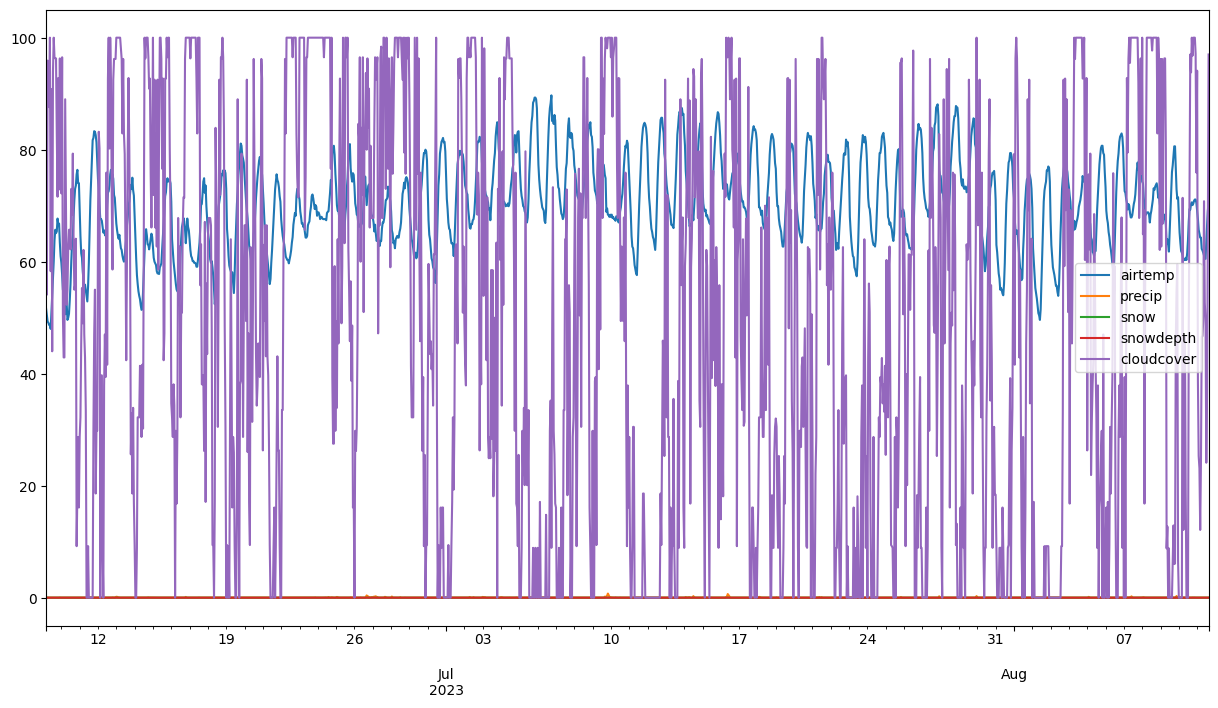

In [251]:
end_dt = datetime.now(timezone.utc) + timedelta(days=3)

data = json.load(open('../src/backend/handlers/dump.json'))

atmos = pd.concat(pd.DataFrame(day['hours']) for day in data['days'])

atmos = atmos.set_index(pd.to_datetime(atmos['datetimeEpoch'], unit='s', utc=True))
atmos = atmos.drop(columns=atmos.columns.difference(list(ATMOSPHERIC_WEATHER_FEATURES.keys()) + ['source']))
atmos = atmos.rename(columns=ATMOSPHERIC_WEATHER_FEATURES)
atmos.index.name = None

atmos_hist = atmos[atmos['source'] == 'obs'].drop(columns=['source'])
atmos_fcst = atmos[atmos['source'] == 'fcst'].drop(columns=['source'])

for df in [atmos_hist, atmos_fcst]:
  for col in df.columns:
    df[col] = df[col].astype('float64')

print(atmos_hist, '\n', atmos_fcst)

atmos_hist.plot()
plt.show()

                           watertemp  streamflow  airtemp  precip  snow  \
2022-08-09 04:00:00+00:00       25.8      1100.0     51.6     0.0   0.0   
2022-08-09 05:00:00+00:00       25.6      1060.0     51.6     0.0   0.0   
2022-08-09 06:00:00+00:00       25.3      1030.0     51.6     0.0   0.0   
2022-08-09 07:00:00+00:00       25.0       978.0     51.6     0.0   0.0   
2022-08-09 08:00:00+00:00       24.7       946.0     51.6     0.0   0.0   
...                              ...         ...      ...     ...   ...   
2023-08-20 21:00:00+00:00       18.4      5390.0     70.6     0.0   0.0   
2023-08-20 22:00:00+00:00       18.3      5310.0     70.6     0.0   0.0   
2023-08-20 23:00:00+00:00       18.2      5230.0     70.6     0.0   0.0   
2023-08-21 00:00:00+00:00       18.0      5190.0     70.6     0.0   0.0   
2023-08-21 01:00:00+00:00       17.7      5100.0     70.6     0.0   0.0   

                           snowdepth  cloudcover  
2022-08-09 04:00:00+00:00        0.0        91.6

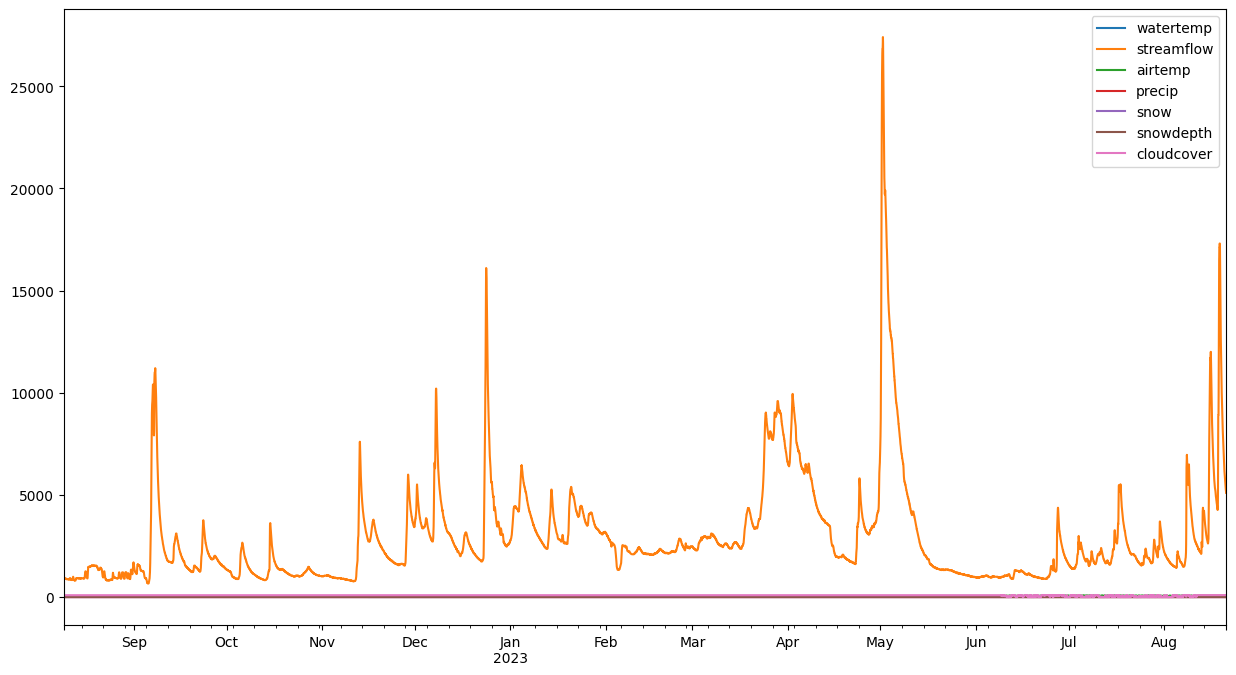

In [252]:
hist = pd.merge(water, atmos_hist, left_index=True, right_index=True, how='outer')

# resample to 30m interval
oidx = hist.index
nidx = pd.date_range(oidx.min().round(TIMESERIES_FREQUENCY), oidx.max().round(TIMESERIES_FREQUENCY), freq=TIMESERIES_FREQUENCY)
hist = hist.reindex(oidx.union(nidx)).interpolate('linear', limit_direction='both').reindex(nidx)

print(hist)

hist.plot()
plt.show()

In [253]:
# reshape data for ddb
new_hist = []
for ts, row in hist.iterrows():
    new_hist.append({
        'usgs_site': '01427510',
        'timestamp': int(ts.timestamp()),
        **row
    })

print('=== new hist ===', *new_hist[:5], f'...{len(new_hist) - 5} more', sep='\n')

new_fcst = []
origin = hist.index.max()
for ts, row in atmos_fcst.iterrows():
    origin = int(hist.index.max().timestamp())
    timestamp = int(ts.timestamp())
    new_fcst.append({
        'usgs_site': '01427510',
        'origin': origin,
        'timestamp': timestamp,
        'origin#timestamp': f'{origin}#{timestamp}',
        **row
    })

print('=== new fcst ===', *new_fcst[:5], f'...{len(new_fcst) - 5} more', sep='\n')

=== new hist ===
{'usgs_site': '01427510', 'timestamp': 1660017600, 'watertemp': 25.8, 'streamflow': 1100.0, 'airtemp': 51.6, 'precip': 0.0, 'snow': 0.0, 'snowdepth': 0.0, 'cloudcover': 91.6}
{'usgs_site': '01427510', 'timestamp': 1660021200, 'watertemp': 25.6, 'streamflow': 1060.0, 'airtemp': 51.6, 'precip': 0.0, 'snow': 0.0, 'snowdepth': 0.0, 'cloudcover': 91.6}
{'usgs_site': '01427510', 'timestamp': 1660024800, 'watertemp': 25.3, 'streamflow': 1030.0, 'airtemp': 51.6, 'precip': 0.0, 'snow': 0.0, 'snowdepth': 0.0, 'cloudcover': 91.6}
{'usgs_site': '01427510', 'timestamp': 1660028400, 'watertemp': 25.0, 'streamflow': 978.0, 'airtemp': 51.6, 'precip': 0.0, 'snow': 0.0, 'snowdepth': 0.0, 'cloudcover': 91.6}
{'usgs_site': '01427510', 'timestamp': 1660032000, 'watertemp': 24.7, 'streamflow': 946.0, 'airtemp': 51.6, 'precip': 0.0, 'snow': 0.0, 'snowdepth': 0.0, 'cloudcover': 91.6}
...9041 more
=== new fcst ===
{'usgs_site': '01427510', 'origin': 1692579600, 'timestamp': 1691769600, 'origin